# Figure 1 d-g: Seismic trace, spectrogram and power 

Reproduces Figure 1 d-g of Köpfli et al. 2022 (GRL).

In [1]:
import obspy
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import datetime
import pandas as pd
from obspy import UTCDateTime

In [2]:
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']

In [3]:
# read seismic data
st = obspy.read('./data/4D.RA92.B.EHZ.D.2020.222')

In [4]:
# response of ASIR geophone
from obspy.signal.invsim import paz_to_freq_resp
poles = [-15.9+22.9j, 15.9-22.9j]
zeros = [0.0 + 0.0j, 0.0 + 0.0j]
scale_fac =  6.4e7 * 82.
h, f = paz_to_freq_resp(poles, zeros, scale_fac, 0.0005, 16384, freq=True)
# interpolate frequency response
from scipy import interpolate
f_int = interpolate.interp1d(f, abs(h), kind='linear')

In [5]:
# read pressure data
df_p = pd.read_csv('./data/pressure_BH11.txt')
df_p.set_index('UTC', inplace=True)
df_p.index = pd.to_datetime(df_p.index).tz_localize(None)
df_p['t'] = [t.timestamp() for t in df_p.index]
df_p['pressure [bar]'] *= 1e5 #
df_p['pressure [bar]'] -= 0.775e5 # minus atmospheric pressure
df_p = df_p[df_p.index>=datetime.datetime(2020,8,9)]
df_p = df_p[df_p.index<datetime.datetime(2020,8,10)]

In [6]:
# read interevent times
import pandas as pd
df_ev = pd.read_csv('./data/event_triggers.txt', names=['trigger'])
df_ev['trigger'] = pd.to_datetime(df_ev['trigger'])
df_ev['dt'] = df_ev['trigger'].diff().dt.total_seconds()
df_ev.set_index('trigger', inplace=True)
df_ev['dtroll'] = df_ev['dt'].rolling('1H').mean()
df_ev.index = df_ev.index - pd.Timedelta('0.5H')
df_ev['t'] = [t.timestamp() for t in df_ev.index]
df_ev = df_ev[df_ev.index>datetime.datetime(2020,8,9)]

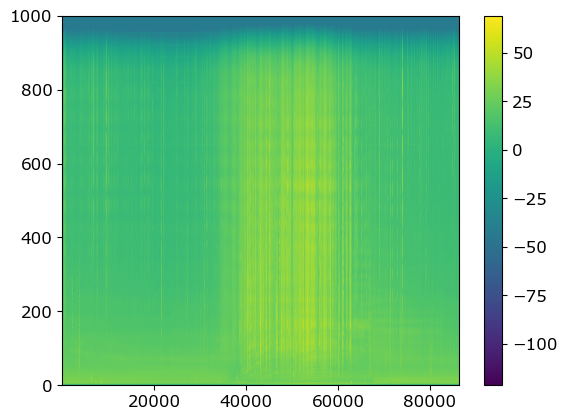

In [7]:
# calculate spectrogram
tr = st[0] # only get one obspy trace from obspy stream
data = tr.data # extract numpy data array from obspy trace
fs = tr.stats.sampling_rate #sampling rate

wlen = 100
NFFT = fs * wlen # bin size for fourier transform. Type in length (seconds)

Pxx, freqs, bins, im = plt.specgram(data, NFFT=int(NFFT), Fs=fs,
                                  noverlap=int(NFFT/1.5), # overlap of bins in samples
                                  detrend='linear',      # detrending before taking fourier transform
                                  mode='psd',            # 'psd', 'magnitude', 'angle', 'phase'
                                  scale_by_freq=True)
plt.colorbar(im)

In [8]:
# remove amplitude response
Pxx_resp = Pxx/(f_int(freqs)[:,None])**2

/var/folders/2c/_9c95l0j7lq3wm599h6nkywc0000gn/T/ipykernel_28450/1252175199.py:2: RuntimeWarning: divide by zero encountered in divide
  Pxx_resp = Pxx/(f_int(freqs)[:,None])**2


/var/folders/2c/_9c95l0j7lq3wm599h6nkywc0000gn/T/ipykernel_28450/597997624.py:165: UserWarning: The handle <matplotlib.lines.Line2D object at 0x165609120> has a label of '_child1' which cannot be automatically added to the legend.
  ax_hydro.legend(lns, labs, loc='lower right', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5),


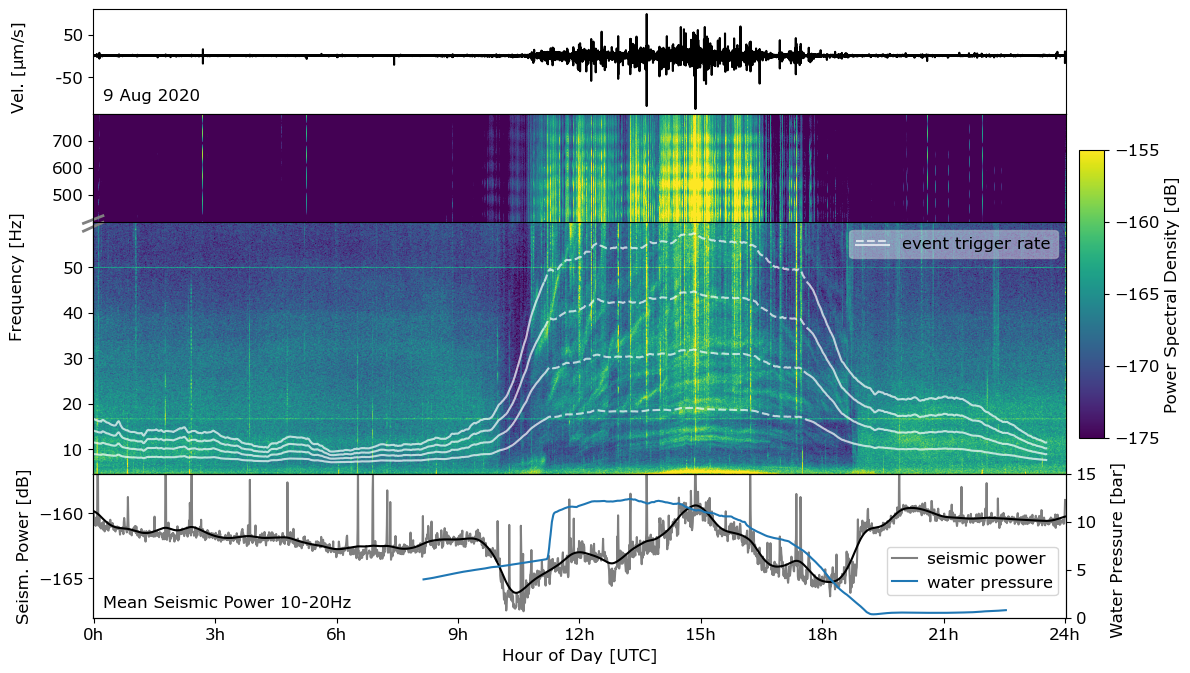

In [9]:
# plotting
fig = plt.figure(figsize=(6.4*2,4.8*1.5)) #create figure and add axes to it
ax_cbar = fig.add_axes([0.895, 0.125+0.2+0.05, 0.02, 0.5-0.1]) # colorbar

# ======================
# Seismogram
ax_seism = fig.add_axes([0.125, 0.125+0.7, 0.76, 0.145])
seism_times = tr.times()+tr.stats.starttime.timestamp
ax_seism.plot(seism_times[::10], tr.data[::10]*1e6/scale_fac, color='k')
ax_seism.set_xlim(np.min(seism_times[::10]), np.max(seism_times[::10]))
ax_seism.axes.xaxis.set_visible(False)
# ax_seism.axes.yaxis.set_visible(False)
ax_seism.set_yticks([-50,50])
ax_seism.set_yticklabels(['-50','50'])
#ax_seism.set_ylabel(r'Vel. $\rm [\mu m/s]$')
fig.text(0.06, 0.89, r'Vel. $\rm [\mu m/s]$', va='center', rotation='vertical', size=12)


# ======================
# high frequency spectrogram
ax_spechigh = fig.add_axes([0.125, 0.125+0.55, 0.76, 0.15]) #[left bottom width height] #[0.125, 0.125, 0.775, 0.755]
spec_times = [(tr.stats.starttime + i).timestamp for i in bins]

Pxx_sub = Pxx_resp[int(400*100):int(800*100),:]
freqs_high = freqs[int(400*100):int(800*100)]
# divide = Pxx_sub#[:,0:500]
# Pxx_sub = Pxx_sub/np.mean(divide, axis=1)[:,None]#Pxx[0:5000,:]

im = ax_spechigh.imshow(10*np.log10(Pxx_sub), origin='lower', 
                aspect='auto',#np.shape(Pxx_sub)[1]/np.shape(Pxx_sub)[0] * (0.3/0.76)/2.5,
                extent=[np.min(spec_times), np.max(spec_times), np.min(freqs_high), np.max(freqs_high)],
#                vmin=-10,
#                vmax=15
                vmax=-155,
                vmin=-175
               )
ax_spechigh.axes.xaxis.set_visible(False)
# ax_spechigh.hlines([400], np.min(spec_times), np.max(spec_times), color='grey', linestyle='dashed', zorder=10)


# ======================
# low frequency spectrogram
ax_speclow = fig.add_axes([0.125, 0.125+0.2, 0.76, 0.35]) #[left bottom width height] #[0.125, 0.125, 0.775, 0.755]

Pxx_sub = Pxx_resp[int(4.6*100):int(60*100),:]
freqs_low = freqs[int(4.6*100):int(60*100)]
# divide = Pxx_sub#[:,0:500]
# Pxx_sub = Pxx_sub/np.mean(divide, axis=1)[:,None]#Pxx[0:5000,:]

im = ax_speclow.imshow(10*np.log10(Pxx_sub), origin='lower', 
                aspect='auto',#np.shape(Pxx_sub)[1]/np.shape(Pxx_sub)[0] * (0.3/0.76)/3,
                extent=[np.min(spec_times), np.max(spec_times), np.min(freqs_low), np.max(freqs_low)],
#                vmin=-10,
#                vmax=15
                vmax=-155,
                vmin=-175
               )
cbar = plt.colorbar(im, cax=ax_cbar)
cbar.ax.locator_params(nbins=5)
cbar.set_label('Power Spectral Density [dB]', fontsize=12) #colorbar label

# ======================
# interevent time
ax_ev = ax_speclow.twinx()

df_res = df_ev.resample('1min').mean()
# select times when the trigger saturated
df_ev_select = df_res[df_res['dtroll']>1/2.2]
df_ev_unselect = df_res[df_res['dtroll']<1/2.2]
df_ev1 = df_ev_select[df_ev_select.index<datetime.datetime(2020,8,9,15)]
df_ev2 = df_ev_select[df_ev_select.index>datetime.datetime(2020,8,9,15)]

# numerator, denominator = signal.butter(2, 1./60/1., 'low') # fs=60s, fc=60min
# dt_unfilt = (1/df_res['dtroll']).tolist()
# dt_lowpass = signal.filtfilt(numerator, denominator, dt_unfilt)

for i in [1,2,3,4]:

    l_evsat = ax_ev.plot(df_ev_unselect['t'], 1/df_ev_unselect['dtroll']*i,
               color='w', linestyle='dashed', 
               label=r'rel. 1/t$\rm _{inter \ (saturated)}$', alpha=0.7)
    
#     l_ev = ax_ev.plot(df_ev_select['t'], 1/df_ev_select['dtroll']*i,
#                color='w', linestyle='', marker='.', markersize=0.5, alpha=0.2, 
#                label=r'rel. 1/t$\rm _{inter}$')
    

#     l_evsat = ax_ev.plot(df_ev_unselect['t'][::int(3e3)], 1/df_ev_unselect['dtroll'][::int(3e3)]*i,
#                color='w',  linestyle='', marker='.', markersize=2, label=r'rel. 1/t$\rm _{inter}$ (saturated)')

    l_ev = ax_ev.plot(df_ev1['t'], 1/df_ev1['dtroll']*i,
               color='w', label=r'rel. 1/t$\rm _{inter}$', alpha=0.7)
    ax_ev.plot(df_ev2['t'], 1/df_ev2['dtroll']*i,
               color='w', alpha=0.7)
#     ax_ev.set_xlim(np.min(seism_times), np.max(seism_times))
    
   # ax_ev.plot(df_res['t'], dt_lowpass*i, color='w', alpha=0.7, linestyle='dashed')
        
ax_ev.axes.yaxis.set_visible(False)

# legend
from matplotlib.legend_handler import HandlerBase
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height], 
                                                linestyle='--', color='w', alpha=0.7)
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], color='w', alpha=0.7)
        return [l1, l2]
# ax_speclow.legend([object], [r'1$\,/\, \rm t \, _{inter-event}$'],
#            handler_map={object: AnyObjectHandler()},loc='upper right', 
#                   framealpha=0.3)
ax_speclow.legend([object], ['event trigger rate'],
           handler_map={object: AnyObjectHandler()},loc='upper right', 
                  framealpha=0.4)



# adjusting ticks and spines
ax_speclow.set_yticks([10,20,30,40,50])
ax_speclow.set_yticklabels(['10','20','30','40','50'])
ax_spechigh.set_yticks([500,600, 700,800])
ax_spechigh.set_yticklabels(['500','600','700','800'])
ax_spechigh.spines['bottom'].set_visible(False)
ax_speclow.spines['top'].set_visible(False)
ax_speclow.axes.xaxis.set_visible(False)



# ======================
# hydraulic tremor
ax_hydro = fig.add_axes([0.125, 0.125, 0.76, 0.2])
spec_times = [(tr.stats.starttime + i).timestamp for i in bins]
powers = np.mean(Pxx_resp[int(10*100):int(20*100),:], axis=0)
dt = list(set(np.round(np.array(spec_times)[1:]-np.array(spec_times)[:-1],3)))[0]
srate = 1/dt
# better filter this data instead of rolling
import scipy.signal as signal
numerator, denominator = signal.butter(2, 1./3600*2./srate, 'low') # fs=60s, fc=60min
p_lowpass = signal.filtfilt(numerator, denominator, powers)
l_power = ax_hydro.plot(spec_times, 10*np.log10(powers), color='k', alpha=0.5, label='seismic power')#label=r'P$\rm _{seis}$')
l_powerfilt = ax_hydro.plot(spec_times, 10*np.log10(p_lowpass), color='k')#, label=r'P$\rm _{seis}$ lowpass')
ax_hydro.set_xlim(np.min(seism_times), np.max(seism_times))
ax_hydro.set_ylim(-168,-157)
ax_hydro.legend(loc='lower right')
ax_hydro.set_ylabel('Seism. Power [dB]')
# box with date into high frequency spectrogram
ax_hydro.text(0.01, 0.05, 'Mean Seismic Power 10-20Hz', transform=ax_hydro.transAxes, fontsize=12,
        verticalalignment='bottom')


# ======================
# water pressure
ax_p = ax_hydro.twinx()
l_p = ax_p.plot(df_p['t'], df_p['pressure [bar]']/1e5-0.8, # subtract air pressure
          color='C0', label='water pressure')#label=r'p$\rm _{water}$')
# ax_p.set_ylabel('Water Pressure [bar]')
ax_p.set_ylim(0,14)
# ax_p.set_xlim(np.min(seism_times), np.max(seism_times))
fig.text(0.92, 0.22, 'Water Pressure [bar]', va='center', rotation='vertical', size=12)

# legend
lns = l_power+l_powerfilt+l_p # for combined legend
labs = [l.get_label() for l in lns] # for combined legend
ax_hydro.legend(lns, labs, loc='lower right', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5), 
                borderpad=0.3, handlelength=1.5, handletextpad=0.6)
ax_p.set_yticks([0,5,10,15])

# ======================
# formatting

# show hour of day on x-axis
h_int = 3
x_ticks = np.arange(0,24+h_int,h_int)
x_tickloc = np.linspace(np.min(spec_times), np.max(spec_times), len(x_ticks))
ax_hydro.set_xticks(x_tickloc)
ax_hydro.set_xticklabels([str(x)+'h' for x in x_ticks])
ax_hydro.set_xlabel('Hour of Day [UTC]', fontsize=12)
fig.text(0.06, 0.6, r'Frequency [Hz]', va='center', rotation='vertical', size=12)

# box with date into high frequency spectrogram
ax_seism.text(0.01, 0.1, tr.stats.starttime.strftime('%-d %b %Y'), transform=ax_seism.transAxes, fontsize=12,
        verticalalignment='bottom')

# axis interruption symbols
d = .01  # how big to make the diagonal lines in axes coordinates
slope_ratio = 0.35/0.2
kwargs = dict(transform=ax_spechigh.transAxes, color='grey', clip_on=False)
ax_spechigh.plot((-d, +d), (-d*slope_ratio*2+0.02, +d*slope_ratio*2+0.02), 
                 linewidth=2, **kwargs) # top-left diagonal
kwargs.update(transform=ax_speclow.transAxes)  # switch to the bottom axes
ax_speclow.plot((-d, +d), (1 - d*slope_ratio-0.02, 1 + d*slope_ratio-0.02), linewidth=2, **kwargs)  # bottom-left diagonal

plt.show()